# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [1]:
useColab=False
if useColab:
    %tensorflow_version 2.x
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
!pip install -r requirements.txt

  Created wheel for kapre: filename=kapre-0.1.7-py3-none-any.whl size=11671 sha256=9a3c319355dee7efc3d1502f8b6c3a32d941ae780f46eb9385a786541369b167


  Stored in directory: c:\users\stefano\appdata\local\pip\cache\wheels\f8\9d\31\aa70157810568e02634f2a6945ae7b4d5e3588de1f14ca6160
  Created wheel for librosa: filename=librosa-0.7.2-py3-none-any.whl size=1612890 sha256=d630b30ece0a2e9ce0385b8ebf1c1c98b080bbe1e56cfe8e2e7ac7c7b091f2d9
  Stored in directory: c:\users\stefano\appdata\local\pip\cache\wheels\cb\1d\15\a479fa740849128d481333d2f354f97691be3e2c82480a3e00
  Created wheel for audioread: filename=audioread-2.1.8-py3-none-any.whl size=23095 sha256=399107a6375e31f6b259bae5f4ea6760b8625b3817aa17535828996ff67b3651
  Stored in directory: c:\users\stefano\appdata\local\pip\cache\wheels\1d\9a\c7\249a5daf5cb90d9786afaec371cba9dc43f04f916db5d1caff
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320723 sha256=2c7655fb0a97fe2f787344c3eb71272aa814f48385dd720222bcef8b077fa2e2
  Stored in directory: c:\users\stefano\appdata\local\pip\cache\wheels\cf\d4\04\49d8824a42bd9f9b11d502727965b9997f0d41d2b22ae4f645
Successfully 

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14591848538039251299
]


In [2]:
#%load_ext autoreload
#%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

C:\Users\stefano\.conda\envs\envProva\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [4]:
# Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task = '12cmd')

Google Speech commands dataset version 2 already exists. Skipping download.
Converting test set WAVs to numpy files


0it [00:00, ?it/s]


Converting training set WAVs to numpy files


0it [00:00, ?it/s]


Done preparing Google Speech commands dataset version 2


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [5]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
84849
12


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [6]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

312

In [7]:
audios, classes = valGen.__getitem__(5)
classes

array([ 0,  0,  6,  0,  0,  0,  0,  5,  0, 10,  2,  0,  6,  0,  5,  7,  0,
       10,  7,  0, 10, 10,  3,  3,  9,  0,  7,  5, 11,  0,  6,  0])

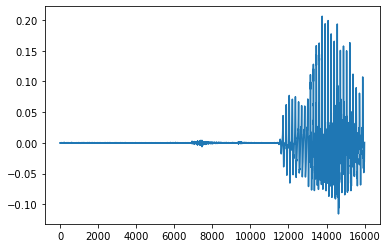

In [8]:
librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
plt.plot(audios[4])

In [8]:
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

C:\Users\stefano\.conda\envs\envProva\lib\site-packages\librosa\filters.py:196: FutureWarning: norm=1 behavior will change in librosa 0.8.0. To maintain forward compatibility, use norm='slaney' instead.
  FutureWarning)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d (Normalizati (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 1,091,664
Non-trainable params: 0
_________________________________________________________________


In [9]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

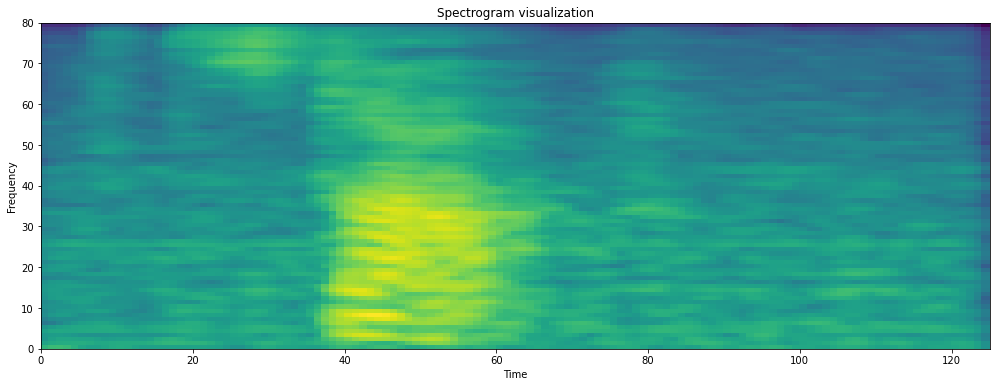

In [10]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[9,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [11]:
# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[0], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)

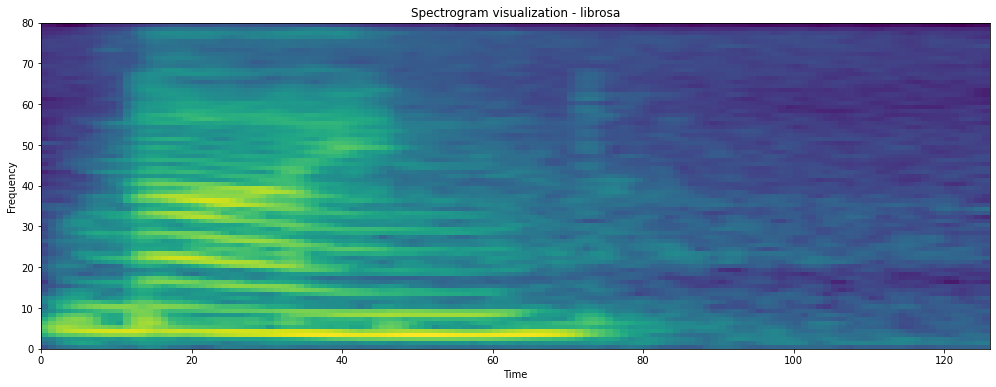

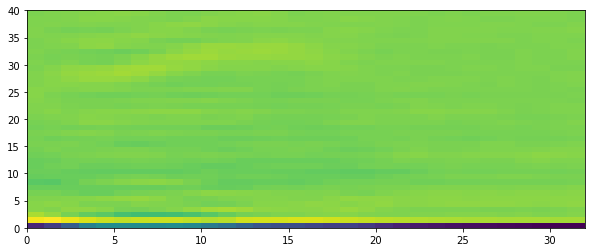

In [12]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()



mfccs=librosa.feature.mfcc(y=audios[0], sr=sr, n_mfcc=40)
plt.figure(figsize=(10, 4))
plt.pcolormesh(mfccs)
plt.show()


In [30]:
#!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5892 sha256=7f1ea786a34b4246b4fb82cb1f144a036bce8b154afee7cb9e7ffd5e5295da9a
  Stored in directory: c:\users\stefano\appdata\local\pip\cache\wheels\6e\e3\24\f8faecfe9da17460cefd7bcdbe3c59ec476339e828fc667515
Successfully built python-speech-features


(99, 26)
(40, 32)


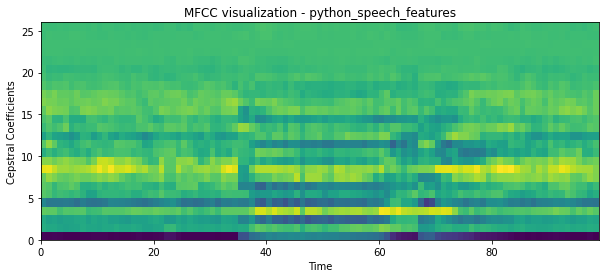

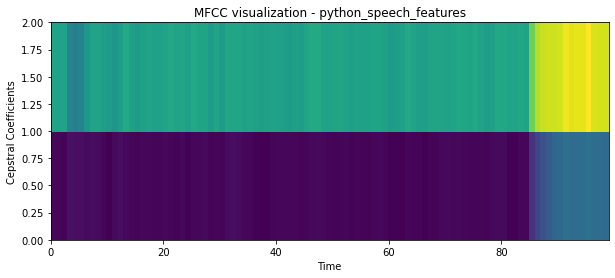

In [81]:
from python_speech_features import mfcc
sig=audios[0]
rate=sr

mfcc_feat = mfcc(sig,rate,numcep=40,appendEnergy=False) #No energy element

print(mfcc_feat.shape)

mfccs=librosa.feature.mfcc(y=sig,sr=sr, n_mfcc=40)
print(mfccs.shape)

###### CANT USE python_speech_features BECAUSE DONT GIVE ALL 40MCCS BUT LIMIT IS 26???

plt.figure(figsize=(10,4))
plt.pcolormesh(mfcc_feat.transpose())
plt.title('MFCC visualization - python_speech_features')
plt.ylabel('Cepstral Coefficients')
plt.xlabel('Time')
plt.show()


import numpy as np
data_array = np.load('sd_GSCmdV2/test/on/0b57a6ed_nohash_0.wav.npy')

mfcc_feat = mfcc(data_array,rate,numcep=2,appendEnergy=False)

plt.figure(figsize=(10,4))
plt.pcolormesh(mfcc_feat.transpose())
plt.title('MFCC visualization - python_speech_features')
plt.ylabel('Cepstral Coefficients')
plt.xlabel('Time')
plt.show()

In [0]:
# plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [0]:
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram

In [146]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_6[0][0]                  
__________________________________________________________________________________________________
mel_stft_norm (Normalization2D) (None, 80, None, 1)  0           mel_stft[0][0]                   
___________________________________________________________________________________________

In [0]:
# model.load_weights('model-attRNN.h5')

In [0]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [149]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save('model-attRNN.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2651 steps, validate for 311 steps
Changing learning rate to 0.001
Epoch 1/60

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.89871, saving model to model-attRNN.h5
2651/2651 - 231s - loss: 0.8172 - sparse_categorical_accuracy: 0.7698 - val_loss: 0.3700 - val_sparse_categorical_accuracy: 0.8987
Changing learning rate to 0.001
Epoch 2/60

Epoch 00002: val_sparse_categorical_accuracy improved from 0.89871 to 0.92203, saving model to model-attRNN.h5
2651/2651 - 255s - loss: 0.3489 - sparse_categorical_accuracy: 0.9021 - val_loss: 0.2874 - val_sparse_categorical_accuracy: 0.9220
Changing learning rate to 0.001
Epoch 3/60

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.92203
2651/2651 - 256s - loss: 0.2694 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.3008 - val_sparse_categorical_accuracy: 0.9140
Changing learning rate to 0.001
Epoch 4/60

Epoch 00004: val_sparse_categorical_accurac

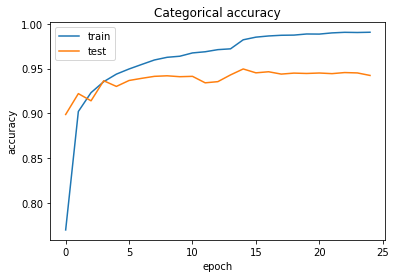

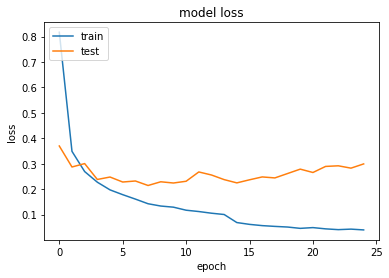

In [150]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# results.history

In [0]:
#load best model according to cross-validation - model-attRNN
model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [0]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [154]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.059317923432161, 0.9857483] 
Validation: [0.21955605431085892, 0.948955] 
Test: [0.23903830211036994, 0.94002724]


In [0]:
kaggle12cmd = False
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    x_testR, y_testR = testRGen.__getitem__(0)
    testREval = model.evaluate(x_testR, y_testR, verbose=1)
    print(testREval)
    testREval = model.evaluate(testRGen, use_multiprocessing=True, workers=4,verbose=1)
    print(testREval)

## Evaluation and Attention Plots

In [0]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [157]:
audios, classes = valGen.__getitem__(3)
classes

array([ 2, 23,  4, 28,  7, 12, 20, 11,  4, 11, 24,  9,  2, 12, 13, 11, 18,
       13, 18,  3,  7, 10, 30, 19, 18,  8, 10, 34, 34,  4, 11, 14])

In [158]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

4

In [0]:
outs, attW, specs = attSpeechModel.predict(audios)

In [160]:
np.argmax(outs,axis=1)

array([ 2, 23,  4, 28,  7, 12, 20, 11,  4, 11, 24,  9,  2,  2, 13, 11, 18,
       13, 18,  3,  7, 10, 30, 19, 18,  8, 10, 34, 34,  4, 11, 14])

In [161]:
specs.shape

(32, 80, 125, 1)

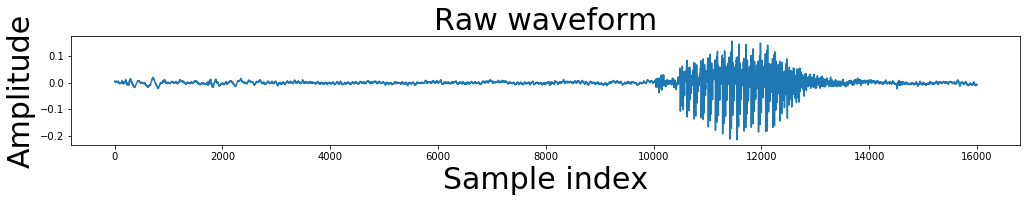

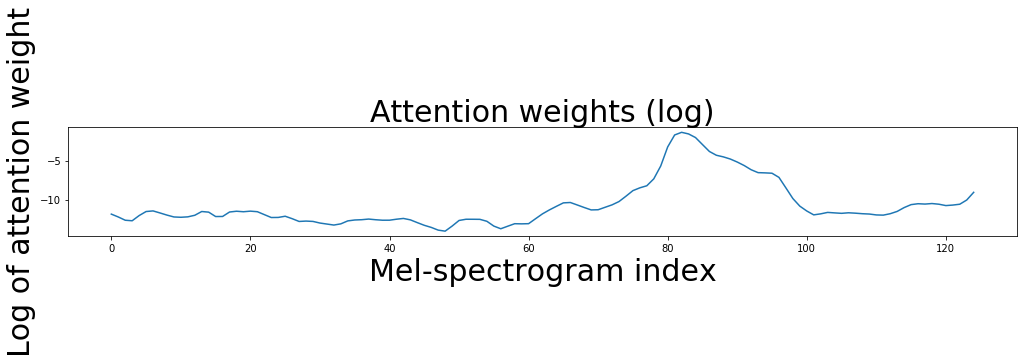

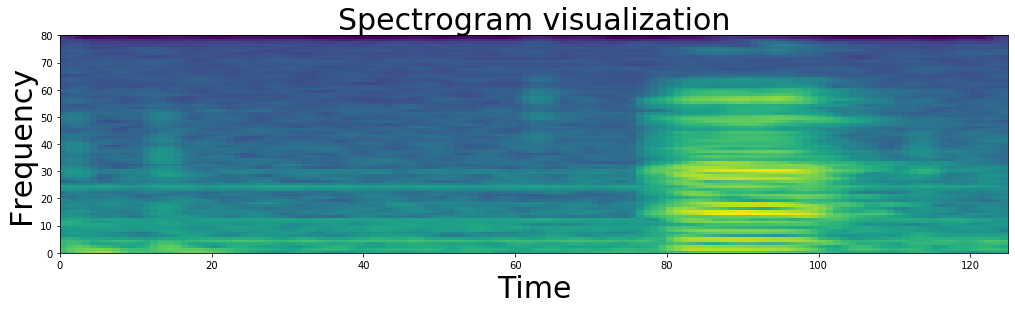

In [162]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [163]:
y_pred = model.predict(x_test, verbose=1)

11005/11005 [==============================] - 24s 2ms/sample


In [0]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [0]:
#set(y_test)

In [0]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [0]:
#35word, v1
#classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
#         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
#         'marvin', 'sheila', 'tree', 'wow']

In [0]:
#20cmd
#classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Confusion matrix, without normalization


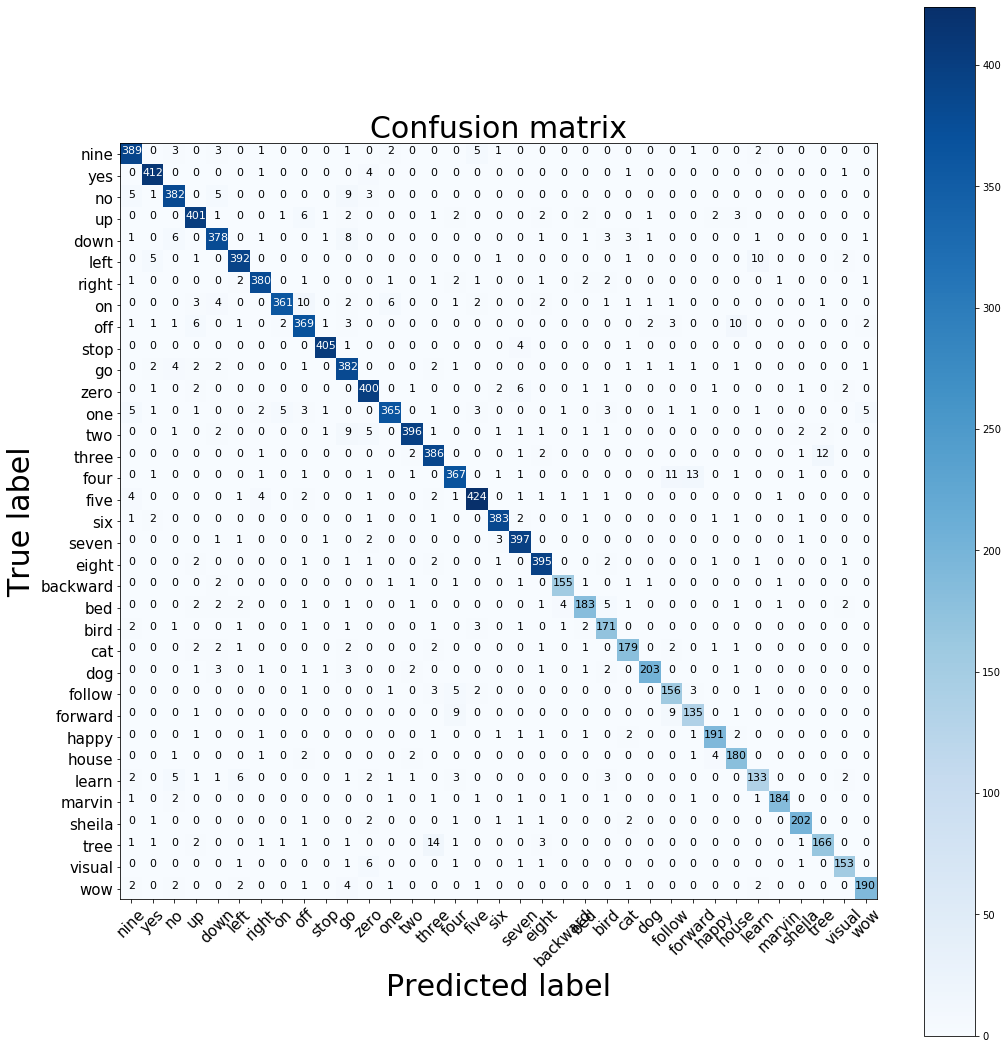

In [169]:
audioUtils.plot_confusion_matrix(cm,classes, normalize=False)

In [170]:
import pandas as pd
import kapre
[tf.__version__, kapre.__version__, pd.__version__, librosa.__version__]

['2.1.0', '0.1.7', '0.25.3', '0.6.3']

# Save model to .pb

In [0]:
# model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
# model.load_weights('model-attRNN.h5')

model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [172]:
tf.saved_model.save(model, "attRNNModel/1/")

INFO:tensorflow:Assets written to: attRNNModel/1/assets


In [173]:
import os
os.listdir('attRNNModel/1/')

['variables', 'saved_model.pb', 'assets']

In [0]:
# if using tensorflow 1.x

In [0]:
# save model to pb ====================
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.
    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph



In [175]:
wkdir = ''
pb_filename = 'attRNN.pb'

# save keras model as tf pb files ===============
sess = tf.compat.v1.keras.backend.get_session()

frozen_graph = freeze_session(sess,
                              output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, wkdir, pb_filename, as_text=False)

AttributeError: ignored